# Getting familiar with Nifti images.

### There are three main parts of this script. 

1. Get images using BIDSLayout.
2. Visulize images using Nilearn and Niwedgets.
3. Do some basic image operations.

## 0. Set-up

Load packages

In [1]:
import bids
from nilearn import image, plotting 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Confirm that subject folder exists

In [2]:
fmriprep_path = '/Users/jimmy/Desktop/FMRI/derivatives/fmriprep'
layout = bids.BIDSLayout(fmriprep_path,validate=False)
print('Subjects:',layout.get_subjects())

Subjects: ['10159']


## 1. Get images 

In this demonstration, preprocessed and normalized **anatomical images (T1-weighted)**  will be used.

**Template** : [MNI152NLin2009cAsym](https://github.com/templateflow/tpl-MNI152NLin6Sym)

Look for T1-weighted data of subject `10159`

In [3]:
T1w_files = layout.get(subject='10159', datatype='anat', suffix='T1w')
for file in T1w_files:
    print(file.path)

/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_desc-preproc_T1w.json
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_desc-preproc_T1w.nii.gz
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_space-MNI152NLin2009cAsym_desc-preproc_T1w.json
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz


we wil use `space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz`.

In [4]:
t1w_nii = image.load_img(T1w_files[3].path)

In [5]:
mask_files = layout.get(subject='10159', datatype='anat', suffix='mask')
for file in mask_files:
    print(file.path)

/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_desc-brain_mask.json
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_desc-brain_mask.nii.gz
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_space-MNI152NLin2009cAsym_desc-brain_mask.json
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz


we will use `space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz`.

In [6]:
mask_nii = image.load_img(mask_files[3].path)

## 2. Visualize images 

There are two common ways to plot neuroimaging data.

- i. `Nilearn.plotting.plot_anat`
- ii. `Niwedgets.NiftiWidget`

### i. Nilearn.plotting.plot_anat

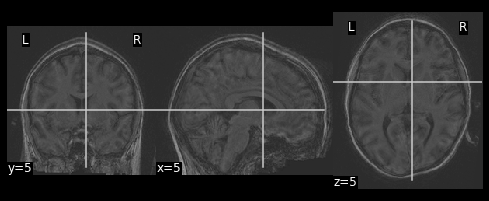

In [7]:
plotting.plot_anat(t1w_nii,cut_coords=(5,5,5))

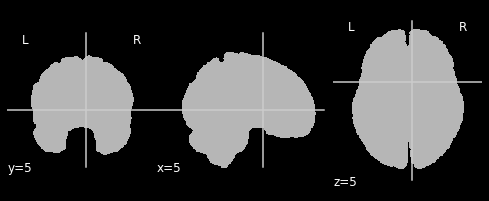

In [8]:
plotting.plot_anat(mask_nii,cut_coords=(5,5,5))

### ii. Niwedgets.NiftiWidget

Alternatively, we can use `Niwidgets`, which provides interactive widgets to visualize data.

Link: https://github.com/nipy/niwidgets

In [9]:
#pip install niwidgets
from niwidgets import NiftiWidget
NiftiWidget(t1w_nii).nifti_plotter()

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=96, continuous_update=False, description='x', max=192), IntSlider(value=…

## 3. Manipulate images 

We will do some image operations.

- Extract the brain
- Remove white matter (WM) from the brain
- Slicing the brain

### Applying a brain mask and extracting the brain

This can be done by simply mutiplying a t1w image with a binary mask.

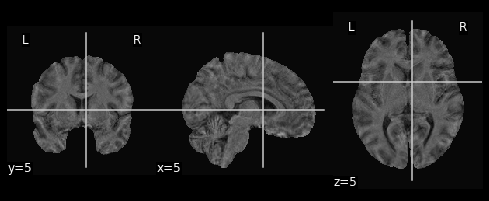

In [10]:
masked_nii = image.math_img('x*y', x=t1w_nii, y=mask_nii)
plotting.plot_anat(masked_nii,cut_coords=(5,5,5))

### Removing WM from the brain

Get the binary mask of WM.

In [11]:
probseg_files = layout.get(subject='10159', datatype='anat', suffix='probseg')
for file in probseg_files:
    print(file.path)

/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_label-CSF_probseg.nii.gz
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_label-GM_probseg.nii.gz
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_label-WM_probseg.nii.gz
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_space-MNI152NLin2009cAsym_label-CSF_probseg.nii.gz
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz
/Users/jimmy/Desktop/FMRI/derivatives/fmriprep/sub-10159/anat/sub-10159_space-MNI152NLin2009cAsym_label-WM_probseg.nii.gz


In [12]:
wm_nii = image.load_img(probseg_files[5].path)

`wm_nii` is the WM probabilistic segmentation (values range from 0 to 1).

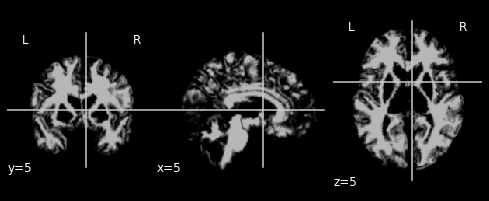

In [13]:
plotting.plot_anat(wm_nii,cut_coords=(5,5,5))

In this example, we will remove regions where the proability of containing WM is greater 0.3.

In [14]:
wm_mask = image.math_img('img > 0.3', img=wm_nii)
no_wm_t1 = image.math_img('x*(1-y)', x=t1w_nii, y=wm_mask)
NiftiWidget(no_wm_t1).nifti_plotter()

<Figure size 432x288 with 0 Axes>

interactive(children=(IntSlider(value=96, continuous_update=False, description='x', max=192), IntSlider(value=…

### Slicing the brain

Get the $100^{\text{th}}$ slice along the y axis.

In [15]:
t1_data = t1w_nii.get_data()
t1_slice = t1_data[:,100,:]
print('t1_slice shape:',t1_slice.shape)

t1_slice shape: (193, 193)


Plot the extracted slice.

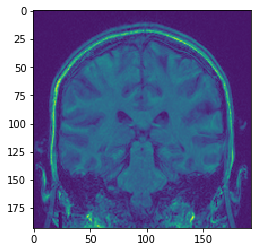

In [16]:
plt.imshow(t1_slice.T[::-1])

## Conclusion

This script covers some basic functions we can use to modify and visualize T1w images using `Nilearn` and `Niwedgets`.

